## FORECASTING CON REDES LSTM - MODELO MULTIVARIADO - MULTISTEP

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('./data/BTCUSDT_data_fixed.csv')
df

c:\Users\cmglezpdev2\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,Open time,Open,High,Low,Close,Volume,Number of trades
0,2017-09-01 00:00:00,4689.89,4767.00,4689.89,4714.73,75.647978,623
1,2017-09-01 04:00:00,4714.73,4734.99,4654.88,4707.50,101.226134,541
2,2017-09-01 08:00:00,4715.00,4798.46,4708.09,4775.00,130.966655,810
3,2017-09-01 12:00:00,4775.00,4839.92,4725.81,4803.83,68.887712,518
4,2017-09-01 16:00:00,4756.46,4815.67,4738.94,4813.24,96.951623,893
...,...,...,...,...,...,...,...
14238,2024-03-01 00:00:00,61130.99,61749.00,60777.00,61105.91,6345.576410,243343
14239,2024-03-01 04:00:00,61105.92,61772.82,61061.11,61434.00,5719.405040,265072
14240,2024-03-01 08:00:00,61434.00,62243.53,61316.67,61863.72,8452.279910,322392
14241,2024-03-01 12:00:00,61863.71,62677.06,61131.01,61263.99,9971.279050,479317


## 5. Pre-procesamiento

Implica:

1. Partición en train/val/test (80%, 10%, 10%)
2. Generación del dataset supervisado: entrada y salida del modelo
3. Escalamiento

Veamos cada una de estas fases.

### 5.1. Partición del set en entrenamiento, validación y prueba

A diferencia de otros modelos de Machine Learning, en el caso de series de tiempo **se debe garantizar que se generan las particiones sin mezclar aleatoriamente los datos**.

Recordemos además que:
- El set de entrenamiento (*train*) se usará para encontrar los parámetros del modelo
- El set de validación (*val*) para verificar que no haya *under/over-fitting* del modelo y para ajustar sus hiperparámetros
- El set de prueba (*test*) para poner a prueba el mejor modelo encontrado durante el entrenamiento/validación

In [2]:
def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1):
  """
  Split a time series into train, validation and test sets.
  """
  N = serie.shape[0]
  train_size = int(tr_size * N)
  val_size = int(vl_size * N)
  test_size = N - train_size - val_size

  train = serie[:train_size]
  val = serie[train_size:train_size + val_size]
  test = serie[train_size + val_size:]

  return train, val, test

In [3]:
tr, vl, ts = train_val_test_split(df['Open'])

print(f'Training set size: {tr.shape}')
print(f'Validation set size: {vl.shape}')
print(f'Testing set size: {ts.shape}')

Training set size: (11394,)
Validation set size: (1424,)
Testing set size: (1425,)


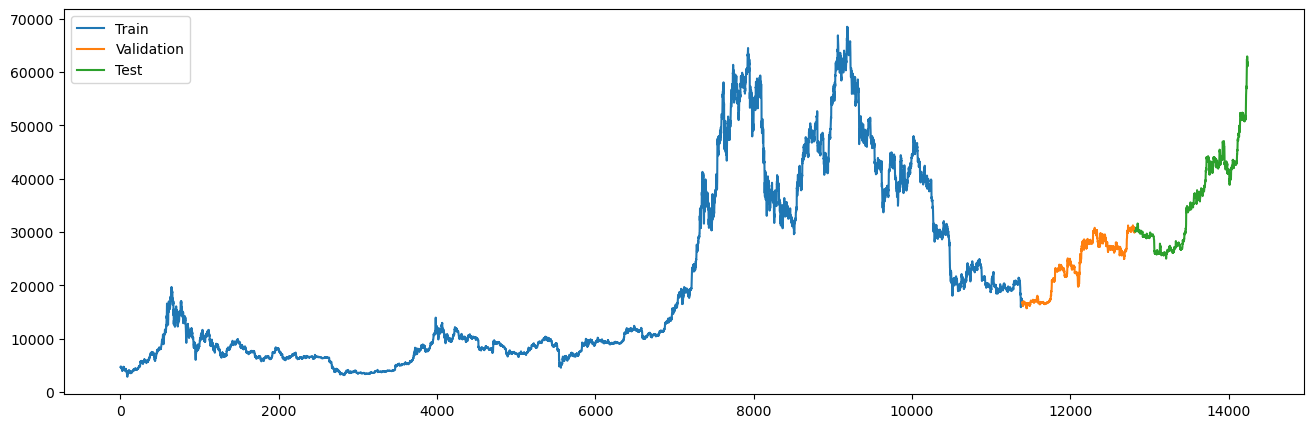

In [4]:
# Dibujar los subsets
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Validation')
ax.plot(ts, label='Test')
plt.legend()

In [5]:
import numpy as np
def create_supervised_dataset(array: np.array, input_length: int, output_length: int):
  """
  Creates a supervised dataset with inputs (X) and outputs (Y) requires for LSTM networks.

  Args:
    array (numpy.ndarray): The input array with size N x features (N:amount of data, f: amount of features).
    input_length (int): Consecutive time instants of the time serie(s) used to feed the model
    output_length (int): Instants of time to be forecast (model output)

  Returns:
    numpy.ndarray: Instants of time to be forecast (model output)
  """

  X, Y = [], []
  shape = array.shape
  if len(shape) == 1:
    # we have a single time serie (univariado)
    rows, cols = array.shape[0], 1
    array = array.reshape(rows, cols)
  else:
    # we have multiple time series (multivariado)
    rows, cols = array.shape
  
  for i in range(rows - input_length - output_length):
    x = array[i:i + input_length, 0:cols]
    y = array[i + input_length:i + input_length + output_length, -1].reshape(output_length, 1)
    X.append(x)
    Y.append(y)
    
  X = np.array(X)
  Y = np.array(Y)
  
  return X, Y

In [6]:
INPUT_LENGTH = 12 # 48 hours
OUTPUT_LENGTH = 4 # 16 hours

x_tr, y_tr = create_supervised_dataset(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = create_supervised_dataset(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = create_supervised_dataset(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Training Set - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Validation Set - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Testing Set - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Training Set - x_tr: (11378, 12, 1), y_tr: (11378, 4, 1)
Validation Set - x_vl: (1408, 12, 1), y_vl: (1408, 4, 1)
Testing Set - x_ts: (1409, 12, 1), y_ts: (1409, 4, 1)


### 5.3 Escalamiento

Es requerido para garantizar que todas las características se encuentran en el mismo rango de valores, lo que facilita el entrenamiento del modelo y las predicciones:

In [7]:
from sklearn.preprocessing import MinMaxScaler

def scale_dataset(data_input):
  '''Escala el dataset en el rango de -1 a 1.

  Entradas:
  data_input: diccionario con los dataset de entrada y salida del modelo
  (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                  'y_ts':y_ts})
  
  Retorna:
  - data_scaled: diccionario con los datasets de entrada y salida escalados
    (tiene la misma estructura del diccionario de entrada)
  - scaler: el escalador usado (requerido para las predicciones)
  '''
  NFEATS = data_input['x_tr'].shape[2]

  # Generar listado con "scalers" (en este caso, por ser sólo 1 característica
  # se tendrá sólo 1 escalador)
  scalers = [MinMaxScaler(feature_range=(-1,1)) for _ in range(NFEATS)]

  # Arreglos que contendrán los datasets escalados
  x_tr_s = np.zeros(data_input['x_tr'].shape)
  x_vl_s = np.zeros(data_input['x_vl'].shape)
  x_ts_s = np.zeros(data_input['x_ts'].shape)
  y_tr_s = np.zeros(data_input['y_tr'].shape)
  y_vl_s = np.zeros(data_input['y_vl'].shape)
  y_ts_s = np.zeros(data_input['y_ts'].shape)

  # Escalamiento: se usarán los min/max del set de entrenamiento para
  # escalar la totalidad de los datasets

  # Escalamiento Xs: en este caso debemos garantizar que cada dato de entrada
  # a fit_transform o transform debe ser de tamaño nsamples x nfeatures
  # (en este caso 24x13)
  for i in range(NFEATS):
      x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
      x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
      x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
  
  # Escalamiento Ys
  y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
  y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
  y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

  # Conformar diccionario de salida
  data_scaled = {
      'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
      'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
      'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
  }

  return data_scaled, scalers[0]

In [8]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar
data_s, scaler = scale_dataset(data_in)

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificación
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'\nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')


Min x_tr/x_vl/x_ts sin escalamiento: 2870.9/15721.51/25020.66
Min x_tr/x_vl/x_ts con escalamiento: -1.0/-0.6083271486503168/-0.32489900044346853

Min y_tr/y_vl/y_ts sin escalamiento: 2870.9/15721.51/25020.66
Min y_tr/y_vl/y_ts con escalamiento: -1.0/-0.6083271486503168/-0.32489900044346853

Max x_tr/x_vl/x_ts sin escalamiento: 68490.0/31255.83/62936.02
Max x_tr/x_vl/x_ts con escalamiento: 1.0/-0.13485768625293548/0.830720628597466

Max y_tr/y_vl/y_ts sin escalamiento: 68490.0/31255.83/62936.02
Max y_tr/y_vl/y_ts con escalamiento: 1.0/-0.13485768625293548/0.830720628597466


## 6. Creación y entrenamiento del modelo

- Entradas: arreglos *x* (batches x input-length  x features = batches x 24 x 1)
- Salidas: arreglos *y* (batches x output-length x features = batches x 1 x 1)

Usaremos la raíz cuadrada del error cuadrático medio (o RMSE por sus siglas en Inglés: *root mean square error*) como pérdida para entrenar el modelo:

$RMSE = \sqrt{\frac{\sum_i (y_i-\hat{y_i})^2}{N}}$

donde:
- $y$: temperatura real
- $\hat{y}$: temperatura predicha
- $N$: cantidad de predicciones

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Adjust parameters for training
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# Model
N_UNITS = 128 # Size of hidden layer (h) and the memory cell(c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])

model = Sequential()
model.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
model.add(Dense(OUTPUT_LENGTH, activation='linear'))

# loss function
def root_mean_squared_error(y_true, y_pred):
  return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(y_pred - y_true)))

# Compilation
optimizer = RMSprop(learning_rate=5e-5)
model.compile(
  optimizer=optimizer,
  loss=root_mean_squared_error
)

# Training
EPOCHS = 80
BATCH_SIZE = 256
history = model.fit(
  x = x_tr_s, 
  y = y_tr_s,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=(x_vl_s, y_vl_s),
  verbose=2
)

Epoch 1/80


c:\Users\cmglezpdev2\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 - 2s - 51ms/step - loss: 0.6423 - val_loss: 0.2862
Epoch 2/80
45/45 - 1s - 30ms/step - loss: 0.5299 - val_loss: 0.2060
Epoch 3/80
45/45 - 2s - 44ms/step - loss: 0.3813 - val_loss: 0.0885
Epoch 4/80
45/45 - 2s - 39ms/step - loss: 0.1874 - val_loss: 0.0590
Epoch 5/80
45/45 - 2s - 43ms/step - loss: 0.1002 - val_loss: 0.0486
Epoch 6/80
45/45 - 2s - 47ms/step - loss: 0.0630 - val_loss: 0.0363
Epoch 7/80
45/45 - 2s - 41ms/step - loss: 0.0384 - val_loss: 0.0264
Epoch 8/80
45/45 - 2s - 46ms/step - loss: 0.0346 - val_loss: 0.0240
Epoch 9/80
45/45 - 2s - 54ms/step - loss: 0.0342 - val_loss: 0.0233
Epoch 10/80
45/45 - 2s - 51ms/step - loss: 0.0339 - val_loss: 0.0229
Epoch 11/80
45/45 - 2s - 42ms/step - loss: 0.0336 - val_loss: 0.0225
Epoch 12/80
45/45 - 2s - 46ms/step - loss: 0.0334 - val_loss: 0.0222
Epoch 13/80
45/45 - 2s - 45ms/step - loss: 0.0332 - val_loss: 0.0220
Epoch 14/80
45/45 - 2s - 39ms/step - loss: 0.0329 - val_loss: 0.0217
Epoch 15/80
45/45 - 1s - 31ms/step - loss: 0.0327 - va

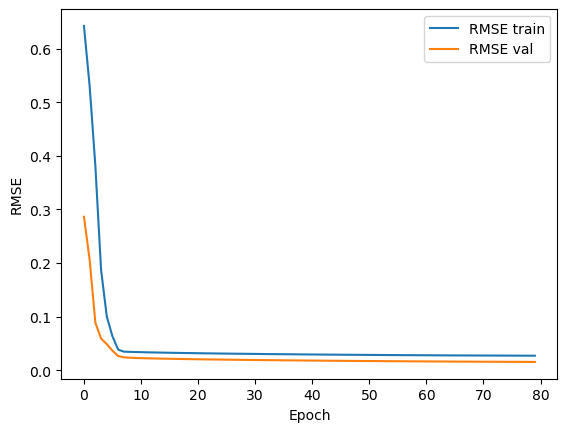

In [10]:
# Plot training and validation curves to check that there is no overfitting
plt.plot(history.history['loss'], label='RMSE train')
plt.plot(history.history['val_loss'], label='RMSE val')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

**Observaciones y sugerencias:**

- El modelo no tiene *overfitting*
- Se sugiere afinar el modelo modificando varios de sus hiperparámetros y usando técnicas como, por ejemplo, *random grid search*. Los hiperparámetros a afinar pueden ser:
  - *INPUT_LENGTH* (esto implica modificar la fase de pre-procesamiento)
  - Número de unidades de la Red LSTM
  - Pérdida
  - Tasa de aprendizaje
  - Epochs
  - Batch size


### Desempeño del modelo

In [11]:
rmse_tr = model.evaluate(x_tr_s, y_tr_s, verbose=0)
rmse_vl = model.evaluate(x_vl_s, y_vl_s, verbose=0)
rmse_ts = model.evaluate(x_ts_s, y_ts_s, verbose=0)

print('Performances:')
print('\tTrain RMSE: %.3f' % rmse_tr)
print('\tValidation RMSE: %.3f' % rmse_vl)
print('\tTest RMSE: %.3f' % rmse_ts)

Performances:
	Train RMSE: 0.020
	Validation RMSE: 0.014
	Test RMSE: 0.019


Los desempeños son comparables lo cual quiere decir que el modelo generaliza bastante bien.
Como en este caso tenemos 4 intevalos de predicciones(en lugar de una sola) podemos analizar cómo se comportaa el error en las predicciones para cada una de los 4 intervalos predichos.

Para eso:
  * Generaremos las predicciones sobre la totalidad del set de prueba con el modelo entrenado.
  * Calcularemos y graficaremos el RMSE para cada instante de tiempo predicho.
  

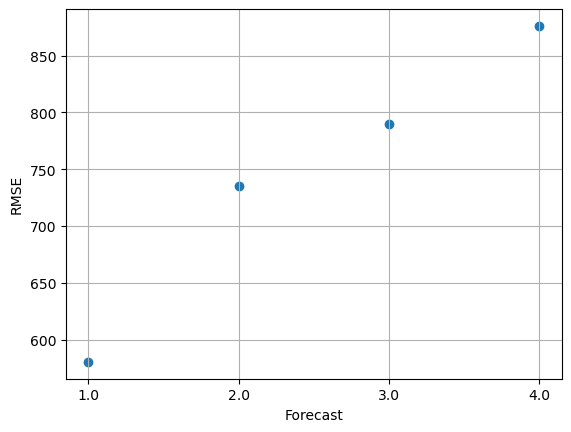

In [12]:
# generate predictions over the training set
import matplotlib.pyplot as plt
y_ts_pred_s = model.predict(x_ts_s, verbose=0)
y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

diff_squeeze = np.square(y_ts.squeeze() - y_ts_pred.squeeze())
proms = np.mean(diff_squeeze, axis=0) # 1x4
rmse = np.sqrt(proms) # 1x4

t = np.linspace(1, 4, 4)
fig, ax = plt.subplots()
ax.scatter(t, rmse)
ax.set_xlabel('Forecast')
ax.set_ylabel('RMSE')
plt.xticks(ticks=t, labels=t)
plt.grid()

### Predicciones con el modelo entrenado

In [13]:
def predict(x, model, scaler):
  '''Genera la predicción de OUTPUT_LENGTH instantes
  de tiempo a futuro con el modelo entrenado.

  Entrada:
  - x: batch (o batches) de datos para ingresar al modelo
    (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
  - model: Red LSTM entrenada
  - scaler: escalador (requerido para llevar la predicción a la escala original)
  
  Salida:
  - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
  '''
    
  y_pred_s = model.predict(x, verbose=0)
  y_pred = scaler.inverse_transform(y_pred_s)
  
  return y_pred.flatten()

In [14]:
# Calculate predictions over testing dataset
y_ts_pred = predict(x_ts_s, model, scaler)

Analicemos este desempeño gráficamente mostrando los precios originales y las predichas por el modelo para cada uno de los datos del set de prueba:

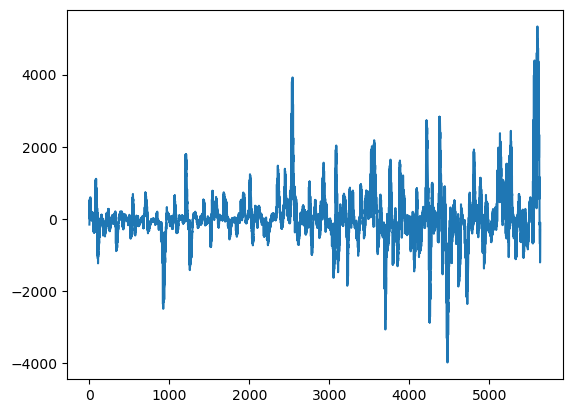

In [15]:
N = len(y_ts_pred)
ndata = np.linspace(1, N, N)

errors = y_ts.flatten() - y_ts_pred
plt.plot(errors)

Se observa que:
- EL promedio de errors es cercano a cero.
- Hay bastantes instantes de tiempo donde se alcanzan errores de hasta -4000 y 4000 dólares de diferencia, aunque el promedio de error esta entre -1500 hasta 2000.